# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist

import typing as tp

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import sklearn
import lightgbm

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from lightgbm import LGBMClassifier

from timeit import default_timer as timer

from joblib import Parallel, delayed

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

x_train_pics = x_train_pics.astype(int)
y_train      = y_train.astype(int)

x_test_pics = x_test_pics.astype(int)
y_test      = y_test.astype(int)

x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test  = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
class RKSClassifier(ClassifierMixin, BaseEstimator):
    """
    Classifier that uses Random Kitchen Sinks (RKS) approach.
    """

    def __init__(
        self,
        base_classifier:     str  = "LogisticRegression",
        n_features:          int  = 1000,
        n_sigma_pairs:       int  = 1000 * 1000,
        new_dim: tp.Optional[int] = 50,
        transform_function        = np.cos,
    ) -> None:
        """
        Make new RKSClassifier instance.
        :param base_classifier: LogisticRegression, LinearSVC or SVC.
        :param n_features: number of features in data.
        :param n_sigma_pairs: number of pairs that are used for sigma estimation.
        :param new_dim: hyperparameter for reducing data dimensionality, use "None" for disabling reduction.
        :return: nothing.
        """

        base_classifiers = {
            "LogisticRegression": LogisticRegression,
            "LinearSVC": LinearSVC,
            "SVC": SVC,
        }
        self.base_classifier_ = base_classifiers[base_classifier]()

        self.n_features_:          int  = n_features
        self.n_sigma_pairs_:       int  = n_sigma_pairs
        self.new_dim_: tp.Optional[int] = new_dim

        self.transform_function_: tp.Callable[..., tp.Any] = transform_function

        self.pca_transformer_: tp.Optional[PCA] = None
        
        self.weights_: tp.Optional[np.array] = None
        self.bias_:    tp.Optional[np.array] = None

        return

    def fit(
        self,
        X: np.array,
        y: np.array,
        *args, 
        **kwargs,
    ) -> "RKSClassifier":
        """
        Fit classifier to train data.
        :param X: matrix with samples from train data.
        :param y: optional target vector.
        :return: self as in sklearn docs.
        """

        new_features = self._generate_new_features(X)

        print("[RKSClassifier] Fitting classifier to train samples...")

        self.base_classifier_.fit(
            X=new_features, 
            y=y,
        )

        print("[RKSClassifier] Successful fitting.")

        return self

    def predict(
        self,
        X: np.array,
    ) -> np.array:
        """
        Make prediction for samples from X.
        :param X: matrix with samples.
        :return: target vector.
        """

        new_features = self._generate_new_features(X)

        print("[RKSClassifier] Making predictions for test data...")

        result = self.base_classifier_.predict(new_features) 

        print("[RKSClassifier] Successful predicting.")

        return result

    def _generate_new_features(
        self,
        X: np.array,
    ) -> np.array:
        """
        Generate new features using cos(<w, x> + b) formula.
        :param X: matrix with samples and features.
        :return: matrix with new features for each sample.
        """

        if self.new_dim_ is not None:
            X = self._reduce_dimensionality(X)

        if self.weights_ is None or self.bias_ is None:
            sigma = self._estimate_sigma(X)
            self.weights_ = self._generate_weights(
                n_coordinates=X.shape[1],
                sigma=sigma,
            )
            self.bias_ = self._generate_bias()

        result = X @ self.weights_ + self.bias_ 
        
        return self.transform_function_(result)

    def _reduce_dimensionality(
        self,
        X: np.array, 
    ) -> np.array:
        """
        Reduce matrix dimensionality using PCA.
        :param X: matrix with samples and features.
        :return: matrix X with reduced dimensionality.
        """

        if not self.pca_transformer_:
            self.pca_transformer_ = PCA(
                n_components=self.new_dim_,
                copy=False,
            )
            self.pca_transformer_.fit(X)

        print("[RKSClassifier:PCA] Predicting...")

        result = self.pca_transformer_.transform(X)

        print("[RKSClassifier:PCA] Successful predicting.")

        return result

    def _estimate_sigma(
        self,
        X: np.array,
    ) -> np.float:
        """
        Estimate sigma hyperparameter for Normal distribution on data X.
        :param X: matrix with samples and features.
        :return: estimated sigma.
        """

        indexes_left, indexes_right = self._generate_indexes(
            max_index=X.shape[0],
        )
        sum_ = np.sum(
            a=(X[indexes_left] - X[indexes_right]) ** 2,
            axis=1,
        )

        sigma_squared = np.median(sum_)
        sigma = np.sqrt(sigma_squared)

        print(f"[RKSClassifier] Estimated sigma = {sigma}")

        return sigma

    def _generate_indexes(
        self,
        max_index: int,
    ) -> np.array:
        """
        Generate sample indexes for sigma estimation.
        :param max_index: used for computing [0, ..., max_index - 1] array for index sampling.
        :return: pair of index arrays.
        """

        indexes = np.random.choice(
            a=np.arange(max_index),
            size=(2, self.n_sigma_pairs_),
        )

        return indexes

    def _generate_weights(
        self,
        n_coordinates: int,
        sigma:         np.float,
    ) -> np.array:
        """
        Generate n_features weight vectors using Normal(0, 1 / sigma^2) distribution.
        :param n_coordinates: number of coordinates in one vector.
        :param sigma: estimated on samples.
        :return: array of vectors (matrix, essentially).
        """

        weights = np.random.normal(
            loc=0.0,
            scale=1.0 / sigma,
            size=(n_coordinates, self.n_features_),
        )

        return weights

    def _generate_bias(
        self,
    ) -> np.array:
        """
        Generate bias vector with n_features coordinates using Uniform[-\pi, \pi] ditribution.
        :param dimensions: number of vector coordinates.
        :return: bias vector.
        """

        bias = np.random.uniform(
            low=-np.pi,
            high=np.pi,
            size=(1, self.n_features_),
        )

        return bias

In [4]:
rks_classifier = RKSClassifier()
rks_classifier = rks_classifier.fit(
    X=x_train,
    y=y_train,
)
predictions = rks_classifier.predict(x_test)
accuracy_score(y_test, predictions)

[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Estimated sigma = 2703.1237799191636
[RKSClassifier] Fitting classifier to train samples...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[RKSClassifier] Successful fitting.
[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


0.8589

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
def get_model(
    features: str = "original",
    kernel:   str = "linear",
) -> tp.Any:
    """
    Get appropriate SVM model.
    :param features: learn and predict using random or original features.
    :param kernel: learn and predict using linear or custom kernel.
    :return: according model.
    """

    models = {
        "original linear":      LinearSVC(),
        "original nonlinear":   SVC(),
        "random linear":        RKSClassifier(base_classifier="LinearSVC", new_dim=None),
        "random nonlinear":     RKSClassifier(base_classifier="SVC",       new_dim=None),
        "random_pca linear":    RKSClassifier(base_classifier="LinearSVC"),
        "random_pca nonlinear": RKSClassifier(base_classifier="SVC"),
    }

    return models[f"{features} {kernel}"]

In [6]:
def benchmark_model(
    model: tp.Any,
    x_train: np.array,
    y_train: np.array,
    x_test:  np.array,
    y_test:  np.array,
) -> tp.Any:
    """
    Get model's predictions accuracy and measure elapsed time.
    :param model: model to benchmark.
    :return: pair (predictions, elapsed time).
    """

    start = timer()

    model.fit(
        X=x_train, 
        y=y_train,
    )
    predictions = model.predict(x_test)

    end = timer()

    elapsed = end - start
    score = accuracy_score(y_test, predictions)

    return score, elapsed

In [7]:
benchmark_results = {}

features, kernel = "original", "linear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
features, kernel = "original", "nonlinear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

In [9]:
features, kernel = "random", "linear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

[RKSClassifier] Estimated sigma = 2927.4476084124885
[RKSClassifier] Fitting classifier to train samples...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[RKSClassifier] Successful fitting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


In [10]:
features, kernel = "random", "nonlinear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

[RKSClassifier] Estimated sigma = 2927.6338568885285
[RKSClassifier] Fitting classifier to train samples...
[RKSClassifier] Successful fitting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


In [11]:
features, kernel = "random_pca", "linear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Estimated sigma = 2704.918218954019
[RKSClassifier] Fitting classifier to train samples...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[RKSClassifier] Successful fitting.
[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


In [12]:
features, kernel = "random_pca", "nonlinear"
result = benchmark_model(
    get_model(features, kernel),
    x_train, y_train,
    x_test,  y_test,
)
benchmark_results[f"{features} {kernel}"] = result

[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Estimated sigma = 2703.3218089610855
[RKSClassifier] Fitting classifier to train samples...
[RKSClassifier] Successful fitting.
[RKSClassifier:PCA] Predicting...
[RKSClassifier:PCA] Successful predicting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


In [13]:
benchmark_results

{'original linear': (0.7509, 298.24271845199996),
 'original nonlinear': (0.8828, 383.99904907700005),
 'random linear': (0.859, 377.14244625699996),
 'random nonlinear': (0.8746, 499.9522385999999),
 'random_pca linear': (0.8716, 326.7530172260001),
 'random_pca nonlinear': (0.8678, 488.275007385)}

В условии задания не было чётко сказано, нужно ли использовать PCA в подходе со случайными признаками, поэтому выше приведены результаты без PCA и с PCA.

Видно, что при использовании линейного ядра подход со случайными признаками даёт качество лучше, чем линейное ядро с исходными (0.86 / 0.87 против 0.75), однако работает он немного дольше (6.3 / 5.4 минут против 5).

Если сравнивать нелинейные ядра, то результат подхода со случайными признаками почти не отличается от подхода с исходными (0.87 / 0.87 против 0.88), однако работает сильно дольше (8.3 / 8.1 минуты против 6.4).

In [14]:
pca_transformer = PCA(
    n_components=50,
    copy=False,
)
pca_transformer.fit(x_train)
x_train_pca = pca_transformer.transform(x_train)

In [15]:
param_grid = {
    "learning_rate": np.logspace(-2, -1, 8),
}

lgbm_estimator = LGBMClassifier(
    objective="multiclass",
)

kfold = KFold(
    n_splits=4,
    shuffle=True,
)

grid_search = GridSearchCV(
    estimator=lgbm_estimator,
    param_grid=param_grid,
    scoring="accuracy",
    cv=kfold,
    n_jobs=-1,
    verbose=100,
)

In [16]:
lgbm_classifier = grid_search.fit(
    X=x_train_pca,
    y=y_train,
)

print(lgbm_classifier)
print(lgbm_classifier.best_params_)
print(lgbm_classifier.cv_results_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=LGBMClassifier(objective='multiclass'), n_jobs=-1,
             param_grid={'learning_rate': array([0.01      , 0.01389495, 0.01930698, 0.02682696, 0.03727594,
       0.05179475, 0.07196857, 0.1       ])},
             scoring='accuracy', verbose=100)
{'learning_rate': 0.1}
{'mean_fit_time': array([22.29163724, 22.60317355, 24.14595866, 24.18593514, 25.43604547,
       24.42161727, 25.09661824, 23.45145839]), 'std_fit_time': array([0.01547466, 1.14731445, 1.07818835, 1.08581832, 1.50003501,
       1.33235046, 1.96392809, 2.17461565]), 'mean_score_time': array([3.0199275 , 2.17271423, 2.13325799, 2.2102946 , 2.05208045,
       2.40162069, 2.54874772, 2.0697754 ]), 'std_score_time': array([0.17206899, 0.21483201, 0.33205621, 0.18588418, 0.17432764,
       0.34547881, 0.37210246, 0.72071067]), 'param_learning_rate': masked_array(data=[0.01,

Оптимальная длина шага: learning_rate = 0.1

In [17]:
param_grid = {
    "n_estimators": np.arange(100, 1000, 100),
}

lgbm_estimator = LGBMClassifier(
    objective="multiclass",
)

kfold = KFold(
    n_splits=4,
    shuffle=True,
)

grid_search = GridSearchCV(
    estimator=lgbm_estimator,
    param_grid=param_grid,
    scoring="accuracy",
    cv=kfold,
    n_jobs=-1,
    verbose=100,
)

In [18]:
lgbm_classifier = grid_search.fit(
    X=x_train_pca,
    y=y_train,
)

print(lgbm_classifier)
print(lgbm_classifier.best_params_)
print(lgbm_classifier.cv_results_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=LGBMClassifier(objective='multiclass'), n_jobs=-1,
             param_grid={'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='accuracy', verbose=100)
{'n_estimators': 900}
{'mean_fit_time': array([ 25.89999771,  48.37843376,  71.87451625,  93.43949926,
       113.53442103, 136.91075933, 193.13135177, 198.08263075,
       184.1141541 ]), 'std_fit_time': array([ 1.80833582,  3.62344785,  4.91133664,  4.80386731,  6.25674624,
       12.37934011,  9.98707667, 14.17224181,  6.06485404]), 'mean_score_time': array([ 2.72426307,  9.1880967 , 14.46625805, 19.83539569, 25.95155746,
       36.23541373, 44.90252143, 37.40175408, 37.23882121]), 'std_score_time': array([0.33802613, 0.45017748, 0.30198706, 0.18229683, 0.43213619,
       1.44820874, 2.05127278, 0.46177321, 5.18952455]), 'param_n_estimators': ma

Оптимальное количество деревеьев: n_estimators = 900

In [19]:
pca_transformer = PCA(
    n_components=50,
    copy=False,
)
pca_transformer.fit(x_train)

x_train_pca = pca_transformer.transform(x_train)
x_test_pca  = pca_transformer.transform(x_test)

In [20]:
lgbm_classifier = LGBMClassifier(
    objective="multiclass",
    learning_rate=0.1,
    n_estimators=900,
)

start = timer()

lgbm_classifier.fit(
    X=x_train_pca,
    y=y_train,
)

lgbm_predictions = lgbm_classifier.predict(x_test_pca)

end = timer()

lgbm_elapsed = end - start

lgbm_score = accuracy_score(
    y_true=y_test,
    y_pred=lgbm_predictions,
)

In [21]:
rks_classifier = RKSClassifier(
    new_dim=None,
)

start = timer()

rks_classifier.fit(
    X=x_train,
    y=y_train,
)

rks_predictions = rks_classifier.predict(x_test)

end = timer()

rks_elapsed = end - start

rks_score = accuracy_score(
    y_true=y_test,
    y_pred=rks_predictions,
)

[RKSClassifier] Estimated sigma = 2926.9800990098993
[RKSClassifier] Fitting classifier to train samples...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[RKSClassifier] Successful fitting.
[RKSClassifier] Making predictions for test data...
[RKSClassifier] Successful predicting.


In [22]:
print(f"Gradient boosting score\t= {lgbm_score},\ttime = {lgbm_elapsed}")
print(f"RKS without PCA score\t= {rks_score},\ttime = {rks_elapsed}")

Gradient boosting score	= 0.8809,	time = 80.03999408300024
RKS without PCA score	= 0.8623,	time = 69.38918591700076


По итогу видно, что градиентный бустинг с подобранными параметрами даёт результат почти на две сотых лучше, однако работает на 10 секунд дольше

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Первую часть задания мы, на самом деле, уже выполнили чуть выше, когда сравнивали несколько вариаций SVM. По результатам проведённых экспериментов видно, что использование PCA в комбинации с SVM не сильно влияет на итоговое качество предсказаний (разница в 0.01), хотя можно и поспорить, является ли улучшение на один процент значимым.

Теперь исследуем зависимость качества предсказаний от n_features

In [23]:
def score_rks_with_(n_features):
    rks_classifier = RKSClassifier(
        n_features=n_features,
    )

    rks_classifier.fit(
        X=x_train,
        y=y_train,
    )

    predictions = rks_classifier.predict(
        X=x_test,
    )

    score = accuracy_score(
        y_true=y_test, 
        y_pred=predictions,
    )

    return score

In [24]:
n_features_range = list(np.arange(200, 4200, 100))
scores = []

with Parallel(n_jobs=4, verbose=100) as parallel:
    scores = parallel(
        delayed(score_rks_with_)(n_features)
        for n_features in n_features_range
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to new file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to new file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-bd1b0d04ba3c40408f6b869313ea2431.pkl
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_1062

[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  4.2min
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-bd1b0d04ba3c40408f6b869313ea2431.pkl
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  5.5min
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m2

[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed: 16.7min
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-bd1b0d04ba3c40408f6b869313ea2431.pkl
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed: 17.4min
Pickling array (shape=(10000,), dtype=int64).
Pickling array (shape=(60000,), dtype=int64).
Memmapping (shape=(60000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m223f0w33rm0000gn/T/joblib_memmapping_folder_10627_4030825822/10627-6321031824-76d24eda752846df80f51933ee5a3691.pkl
Memmapping (shape=(10000, 784), dtype=int64) to old file /var/folders/ws/2x2rgp1x619c6m2

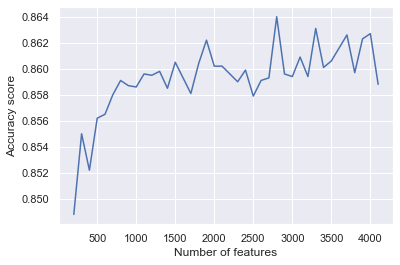

In [25]:
df_to_draw = pd.DataFrame(
    data={
        "n_features": n_features_range, 
        "score":      scores,
    },
)

ax = sns.lineplot(
    x="n_features",
    y="score",
    data=df_to_draw,
)
_ = ax.set(
    xlabel="Number of features",
    ylabel="Accuracy score",
)

Видно, что, если пренебречь небольшой погрешностью, качество с увеличением количества новых признаков спустя какое-то время стабилизируется и колеблется в некотором небольшом интервале (то есть, "выходит на плато").

Если сравнивать логистическую регрессию и SVM (что мы неявно делали на протяжении этих заданий), то можно заметить, что первая модель работает значительно быстрее, однако ограничение сверху по достижимому качеству у SVM выше (что, в принципе, логично).

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪